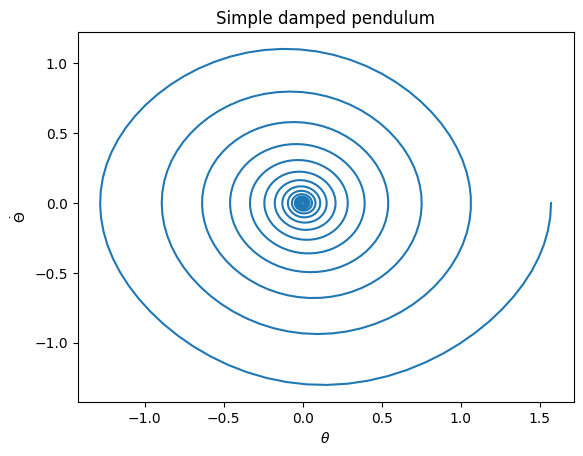

In [143]:
#non-chaotic damped pendulum
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

def simple_pendulum(y,t, v):
    theta, theta_dot = y
    dydt = [theta_dot, -( v*theta_dot + np.sin(theta))]
    return dydt

def simple_solution(y,t):
    v = 0.1
    solns = odeint(simple_pendulum, y, t, args=(v,)) #solving the differntial eqs
    return solns[:,0], solns[:,1] 

def simple_plot(y, t):
    theta, theta_dot = simple_solution(y,t)
    plt.title("Simple damped pendulum")
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\Theta}$")
    return plt.plot(theta, theta_dot)
    
N = 1000 #number of points
t = np.linspace(0,100,N) #amount of time to calc for
y_0 = [np.pi / 2, 0] #initial conditions
simple_plot(y_0, t)
plt.show()

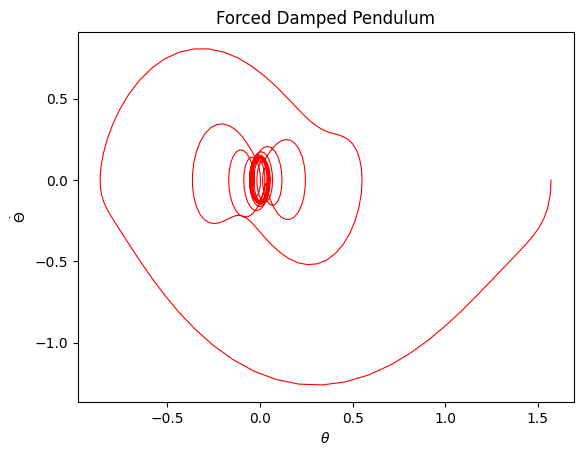

In [119]:
#chaotic forced damped pendulum

def chaotic_pendulum(y, t, v, T, F):
    theta, theta_dot = y
    dydt = [theta_dot, -v*theta_dot - np.sin(theta) + T*np.sin(2*np.pi*F*t)]
    return dydt

def chaotic_solution(y, t):
    v = 0.3 #dampening term
    T = 0.4 #forcing term
    F = 0.5 #frequency of forcing term
    solns = odeint(chaotic_pendulum, y, t, args=(v,T,F))
    return solns[:, 0], solns[:, 1]

def chaotic_plot(y, t):
    theta, theta_dot = chaotic_solution(y, t)
    plt.plot(theta, theta_dot, color = 'r', lw=0.8)
    plt.title("Forced Damped Pendulum")
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\Theta}$")
    return plt.show() 

N = 1000 #number of points
t = np.linspace(0,100,N) #amount of time to calc for
y_0 = [np.pi / 2, 0] #initial conditions
chaotic_plot(y_0, t)

Now to gather as data

In [168]:
#simple damped pendulum
#using the previous 5 points can the model predict the next point 

N = 1000 #number of points
t = np.linspace(0,100,N) #amount of time to calc for
y_0 = [np.pi / 2, 0] #initial conditions

def time_series_data(function):
    theta, theta_dot = function(y_0, t)
    combined = np.stack((theta, theta_dot), axis = 1)
    steps = 5
    inputs = []
    outputs = []
    for i in range(len(combined) - steps - 1):
        input = combined[i : i + steps, :]
        output = combined[i + steps, :]
        inputs.append(input)
        outputs.append(output)

    return np.array(inputs), np.array(outputs)

def splitting_data(simple_or_chaotic_solution):
    inputs, outputs = time_series_data(simple_or_chaotic_solution)
    X_train, y_train = inputs[0 : int(len(inputs) / 10)], outputs[0 : int(len(outputs) / 10)]
    X_test, y_test = inputs, outputs
    return X_train, y_train, X_test, y_test

In [169]:
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras import optimizers

def building_and_training(simple_or_chaotic_solution):
    model = Sequential([
        layers.LSTM(units= 50, activation='relu', input_shape=(5,2)),
        layers.Dense(units=32),
        layers.Dense(units=16),
        layers.Dense(units= 2) #only two layres because it is linear
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
    print(model.summary())
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    return model

In [170]:
X_train, y_train, X_test, y_test = splitting_data(simple_solution)
model = building_and_training(simple_solution)
def prediction_plot(model):
    y_pred = model.predict(X_test)
    theta_pred, theta_dot_pred = y_pred[:, 0], y_pred[:, 1]
    return plt.plot(theta_pred, theta_dot_pred)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 50)             │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,794 (49.98 KB)

 Trainable params: 12,794 (49.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.4452 - val_loss: 0.0324
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0874 - val_loss: 0.1024
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0646 - val_loss: 0.0038
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0306 - val_loss: 0.0289
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0319 - val_loss: 0.0026
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0119 - val_loss: 0.0058
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0165 - val_loss: 0.0131
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - val_loss: 4.3534e-04
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0047 - val_loss: 0.0078


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


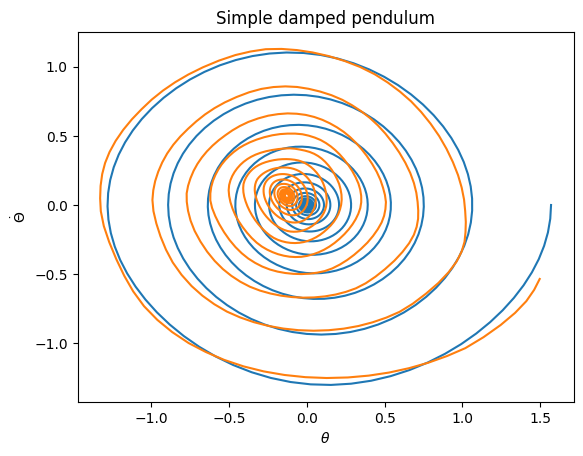

In [171]:
N = 1000 #number of points
t = np.linspace(0,100,N) #amount of time to calc for
y_0 = [np.pi / 2, 0] #initial conditions

simple_plot(y_0, t)
prediction_plot(model)
plt.show()

**Now forced damped pendulum**

In [172]:
X_train, y_train, X_test, y_test = splitting_data(chaotic_solution)
model = building_and_training(chaotic_solution)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 50)             │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,794 (49.98 KB)

 Trainable params: 12,794 (49.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.2106 - val_loss: 0.0064
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0444 - val_loss: 0.0326
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0355 - val_loss: 0.0063
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0272 - val_loss: 0.0023
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0232 - val_loss: 0.0119
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0094 - val_loss: 0.0189
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0107 - val_loss: 0.0128
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0059 - val_loss: 0.0036


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


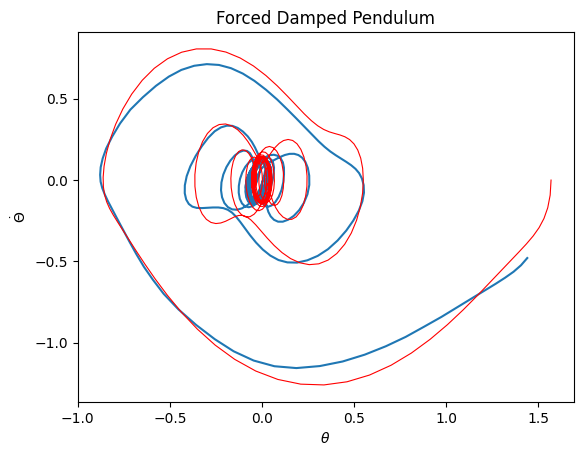

In [173]:
N = 1000 #number of points
t = np.linspace(0,100,N) #amount of time to calc for
y_0 = [np.pi / 2, 0] #initial conditions

prediction_plot(model)
chaotic_plot(y_0, t)
plt.show()